IMPORTAÇÕES (Executar antes)

In [1]:
import math
import random
from random import randrange
from deap import creator, base, tools, algorithms
import numpy as np 
import pandas as pd
import seaborn as sns; 
import matplotlib.pyplot as plt

GA (Implementado de forma genérica/Necessário atualizar as variáveis globais)

In [2]:
#Atualizar antes da execução
n_clusters = 0
datasettestado =  ''
dic_cluster = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

In [3]:
def distanciaEuclidiana(ponto1, ponto2):
    x1,y1 = ponto1
    x2,y2 = ponto2
    
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

In [103]:
#Converte de binário para decimal
def converte_individuos(individual, k):

    individuos = []
    c = 0
    
    for i in range(0,k*2):
        aux = ''        
        for j in range(c, 7+c):
            aux = aux + str(individual[j])            
        c +=7
        aux = int(aux, 2)
        individuos.append(aux)    
    
    return individuos

In [130]:
def separa_clusters(dataset, individuos, k):    
    #iniciliza os clusters 
    clusters = []    
    j = 0
    
    for l in range(0,k):
        aux = []
        clusters.append(aux)

    #calcula a distância euclidiana para todos os pontos do dataset
    for item in dataset:
        c = []
        i = 0
        j = 0         
        for i in range(0,k):
            item2 = (individuos[j], individuos[j+1])
            c.append(distanciaEuclidiana(item, item2))
            j+=2
  
        #encontra a menor distância para adicionar o elemento ao cluster correto        
        indice = c.index(min(c))
        
        clusters[indice].append(item)
    #print(clusters)
    return clusters

In [30]:
def atualiza_centroides(individuos, k, clusters):
    
    novos_centroides = []
    j = 0
    
    for i in range(0, k):        
        aux = [individuos[j], individuos[j+1]]
        j += 2
        novos_centroides.append(aux)
        
        for aux in clusters[i]:
            x, y = aux            
            novos_centroides[i][0] += x
            novos_centroides[i][1] += y 
            
        novos_centroides[i][0] = novos_centroides[i][0]/(len(clusters[i])+1)
        
    return novos_centroides

In [133]:
#Função de avaliação individual de cada individuo
def evalOneMax(individual):
    
    #print(individual)
    
    #Faz a conversão para decimal
    individuos = converte_individuos(individual, n_clusters)
    print("ind: " + str(individuos))
    
    #Fase 1: distancia euclidiana em função dos pontos do dadaset e definição dos clusters 
    clusters = separa_clusters(datasettestado, individuos, n_clusters)
    
    #Fase 2: atualização do centroides dos clusters    
    novos_centroides = atualiza_centroides(individuos, n_clusters, clusters)
    
    #Apartir dos novos centroides as distâncias são recalculadas, gerando a função de avaliação
    m = 0
    j = 0
    c = 0

    for lista in clusters:        
        for item in lista:            
            m += distanciaEuclidiana(item, (novos_centroides[c][j], novos_centroides[c][j+1]))            
        c += 1
        
    if m != 0:
        f = 1/m
    else: 
        f = 0

    return f,

In [8]:
def GA():

    ## creating fitness values and weights
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()

    # Each gene (cluster) is assigned 1 or 0
    toolbox.register("attr_bool", random.randint, 0, 1)
    # total genes in a chromosome(individual) = set to 100 (the more genes the better result)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=28) 
    # creating population from all the chromosomes
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)


    # evaluation of each chromosome
    toolbox.register("evaluate", evalOneMax)
    # mating / cross-over of two chromosomes
    toolbox.register("mate", tools.cxTwoPoint)
    # mutation with mutation probability = 0.05
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.5)
    # tournament selection with size =3
    toolbox.register("select", tools.selTournament, tournsize=3)

    # creating total population of size 300
    population = toolbox.population(n=300)

    # next generation size = 40
    NGEN=40
    for gen in range(NGEN):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.8, mutpb=0.5)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
        population = toolbox.select(offspring, k=len(population))

    # selecting top 3 best chromosomes    
    top10 = tools.selBest(population, k=10)
    return top10

PLOT - Genérico

In [9]:
def gera_pontos(cluster, id_cluster):
    x_list = []
    y_list = []
    tipo_cluster = []
    
    for i in cluster:
        x, y = i
        x_list.append(x)
        y_list.append(y)
        tipo_cluster.append(id_cluster)
        
    return x_list, y_list, tipo_cluster

In [77]:
def gera_dataframe(dataset, k, res):
    x_list = []
    y_list = []
    id_cluster = []
    c = 0

    centroides = converte_individuos(res, k)
    clusters = separa_clusters(dataset, centroides, k)

    for item in clusters:
        x, y, idi_cluster = gera_pontos(item, dic_cluster[c])
        x_list = x_list + x
        y_list = y_list + y
        id_cluster =  id_cluster + idi_cluster        
        c +=1

    data = {'x': x_list,
            'y': y_list,
            'Cluster': id_cluster}

    # Create DataFrame
    df = pd.DataFrame(data)

    return df    

In [73]:
def gera_plot(dataset, k, res):
    df = gera_dataframe(dataset, k, res)
    tips = sns.load_dataset("tips")
    ax = sns.scatterplot(x="x", y="y",hue="Cluster", data=df)

Experiment 1

In [12]:
random.seed(9001) #Para gerar sempre a mesma sequência

# Criação de 3 datasets com 10 pontos gerados aleatoriamente no R²
dataset1 = [(randrange(127), randrange(127)) for _ in range(10)]
dataset2 = [(randrange(127), randrange(127)) for _ in range(10)]
dataset3 = [(randrange(127), randrange(127)) for _ in range(10)]          

/home/karine/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/karine/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


ind: [44, 7, 59, 127]
ind: [63, 123, 15, 66]
ind: [120, 28, 75, 46]
ind: [92, 80, 62, 20]
ind: [14, 84, 65, 19]
ind: [65, 77, 94, 55]
ind: [54, 44, 69, 98]
ind: [124, 69, 34, 46]
ind: [112, 35, 61, 5]
ind: [78, 35, 21, 108]
ind: [103, 81, 29, 60]
ind: [12, 50, 62, 42]
ind: [123, 109, 19, 19]
ind: [14, 71, 18, 83]
ind: [6, 103, 95, 49]
ind: [32, 26, 52, 106]
ind: [63, 10, 108, 35]
ind: [91, 119, 37, 92]
ind: [83, 60, 119, 87]
ind: [126, 123, 21, 60]
ind: [113, 69, 96, 9]
ind: [87, 117, 3, 24]
ind: [58, 48, 124, 55]
ind: [42, 55, 45, 59]
ind: [49, 1, 63, 85]
ind: [18, 5, 29, 48]
ind: [48, 49, 40, 39]
ind: [59, 117, 72, 88]
ind: [63, 56, 27, 109]
ind: [41, 70, 12, 38]
ind: [39, 40, 62, 20]
ind: [88, 66, 24, 79]
ind: [76, 47, 14, 101]
ind: [125, 66, 1, 91]
ind: [18, 108, 58, 110]
ind: [113, 121, 81, 14]
ind: [67, 35, 53, 18]
ind: [0, 15, 122, 122]
ind: [2, 74, 5, 77]
ind: [110, 89, 85, 10]
ind: [76, 93, 32, 21]
ind: [107, 90, 27, 17]
ind: [11, 105, 32, 60]
ind: [110, 115, 31, 70]
ind: [4, 

ind: [94, 39, 94, 32]
ind: [41, 4, 52, 109]
ind: [13, 113, 56, 39]
ind: [59, 13, 116, 96]
ind: [59, 70, 41, 8]
ind: [25, 85, 119, 100]
ind: [86, 47, 64, 113]
ind: [107, 61, 13, 58]
ind: [7, 104, 97, 60]
ind: [90, 43, 114, 75]
ind: [51, 26, 75, 119]
ind: [107, 8, 42, 75]
ind: [9, 94, 53, 99]
ind: [59, 22, 60, 57]
ind: [109, 87, 83, 26]
ind: [42, 98, 92, 94]
ind: [60, 55, 5, 59]
ind: [43, 118, 34, 44]
ind: [120, 110, 67, 14]
ind: [123, 96, 95, 7]
ind: [21, 51, 92, 43]
ind: [68, 8, 25, 95]
ind: [13, 37, 110, 20]
ind: [40, 54, 90, 12]
ind: [71, 66, 93, 19]
ind: [39, 100, 35, 57]
ind: [2, 88, 10, 9]
ind: [32, 116, 16, 43]
ind: [107, 72, 83, 26]
ind: [37, 19, 126, 112]
ind: [25, 117, 94, 62]
ind: [16, 55, 32, 12]
ind: [106, 76, 73, 106]
ind: [105, 63, 63, 1]
ind: [12, 34, 28, 16]
ind: [92, 123, 123, 24]
ind: [91, 90, 66, 75]
ind: [74, 43, 115, 76]
ind: [35, 127, 68, 39]
ind: [38, 11, 114, 64]
ind: [22, 61, 101, 76]
ind: [105, 63, 97, 10]
ind: [32, 57, 68, 19]
ind: [37, 106, 33, 111]
ind: [54

ind: [23, 114, 108, 107]
ind: [39, 28, 31, 1]
ind: [120, 48, 40, 27]
ind: [53, 26, 116, 83]
ind: [2, 77, 13, 79]
ind: [101, 86, 1, 37]
ind: [73, 13, 25, 108]
ind: [47, 26, 8, 17]
ind: [99, 71, 31, 22]
ind: [76, 92, 91, 27]
ind: [48, 80, 106, 108]
ind: [9, 122, 115, 35]
ind: [116, 35, 108, 59]
ind: [1, 13, 123, 118]
ind: [70, 2, 62, 107]
ind: [54, 36, 96, 119]
ind: [79, 41, 111, 58]
ind: [44, 99, 10, 68]
ind: [25, 0, 59, 85]
ind: [33, 66, 45, 59]
ind: [63, 75, 88, 48]
ind: [36, 56, 69, 93]
ind: [94, 123, 119, 17]
ind: [95, 109, 104, 77]
ind: [25, 100, 120, 11]
ind: [9, 2, 39, 109]
ind: [56, 96, 89, 4]
ind: [44, 112, 79, 91]
ind: [101, 43, 18, 51]
ind: [90, 43, 62, 11]
ind: [89, 51, 114, 73]
ind: [111, 116, 55, 93]
ind: [125, 40, 55, 100]
ind: [108, 48, 72, 16]
ind: [125, 15, 11, 5]
ind: [4, 16, 115, 105]
ind: [17, 103, 80, 20]
ind: [27, 104, 101, 32]
ind: [113, 9, 107, 41]
ind: [72, 34, 29, 116]
ind: [67, 63, 72, 34]
ind: [30, 39, 119, 23]
ind: [18, 15, 80, 20]
ind: [71, 55, 68, 84]
ind

ind: [4, 104, 27, 11]
ind: [6, 85, 13, 15]
ind: [84, 77, 77, 90]
ind: [30, 19, 32, 125]
ind: [16, 103, 94, 12]
ind: [118, 111, 90, 35]
ind: [88, 52, 12, 19]
ind: [36, 20, 91, 11]
ind: [63, 20, 26, 119]
ind: [126, 37, 69, 96]
ind: [88, 103, 94, 8]
ind: [115, 55, 74, 34]
ind: [48, 76, 82, 42]
ind: [77, 16, 38, 72]
ind: [24, 120, 116, 29]
ind: [9, 44, 103, 46]
ind: [80, 119, 91, 10]
ind: [73, 5, 30, 55]
ind: [48, 3, 0, 38]
ind: [124, 60, 67, 94]
ind: [25, 105, 107, 53]
ind: [115, 108, 42, 14]
ind: [36, 20, 91, 11]
ind: [11, 72, 108, 96]
ind: [90, 23, 116, 27]
ind: [77, 48, 70, 78]
ind: [73, 5, 12, 55]
ind: [55, 2, 63, 101]
ind: [46, 8, 3, 97]
ind: [17, 86, 111, 81]
ind: [20, 122, 69, 71]
ind: [122, 17, 45, 36]
ind: [77, 126, 115, 35]
ind: [36, 20, 91, 11]
ind: [80, 121, 12, 7]
ind: [73, 41, 95, 102]
ind: [84, 41, 90, 74]
ind: [113, 21, 14, 52]
ind: [83, 102, 122, 57]
ind: [125, 76, 46, 110]
ind: [12, 94, 79, 96]
ind: [29, 1, 119, 121]
ind: [51, 55, 22, 96]
ind: [8, 5, 44, 18]
ind: [24, 97

ind: [70, 3, 56, 113]
ind: [0, 17, 6, 66]
ind: [19, 25, 7, 77]
ind: [77, 2, 85, 108]
ind: [75, 60, 54, 92]
ind: [71, 72, 2, 81]
ind: [89, 99, 36, 122]
ind: [40, 103, 94, 13]
ind: [55, 90, 3, 62]
ind: [63, 49, 48, 27]
ind: [45, 74, 35, 30]
ind: [0, 68, 1, 81]
ind: [36, 20, 90, 11]
ind: [35, 105, 60, 31]
ind: [43, 10, 118, 54]
ind: [103, 125, 7, 127]
ind: [119, 27, 108, 54]
ind: [53, 47, 121, 123]
ind: [80, 68, 91, 11]
ind: [44, 47, 94, 60]
ind: [54, 115, 59, 22]
ind: [63, 30, 66, 66]
ind: [64, 113, 79, 54]
ind: [124, 43, 51, 88]
ind: [108, 35, 85, 113]
ind: [46, 3, 90, 78]
ind: [44, 34, 85, 61]
ind: [73, 6, 16, 55]
ind: [29, 23, 34, 47]
ind: [43, 38, 15, 55]
ind: [40, 20, 60, 99]
ind: [36, 20, 91, 8]
ind: [77, 48, 70, 78]
ind: [38, 51, 26, 7]
ind: [28, 23, 103, 67]
ind: [36, 108, 117, 11]
ind: [36, 20, 91, 8]
ind: [73, 6, 16, 55]
ind: [22, 53, 126, 12]
ind: [122, 56, 14, 112]
ind: [90, 85, 11, 118]
ind: [38, 63, 104, 16]
ind: [36, 17, 53, 11]
ind: [94, 72, 104, 107]
ind: [8, 73, 100, 12

ind: [31, 41, 3, 12]
ind: [0, 19, 6, 2]
ind: [30, 41, 18, 5]
ind: [23, 76, 95, 94]
ind: [16, 20, 53, 58]
ind: [36, 20, 87, 8]
ind: [49, 26, 42, 20]
ind: [22, 0, 2, 61]
ind: [32, 41, 118, 53]
ind: [102, 21, 115, 115]
ind: [54, 2, 111, 19]
ind: [67, 68, 20, 117]
ind: [108, 109, 56, 29]
ind: [102, 28, 44, 12]
ind: [36, 73, 109, 0]
ind: [73, 31, 109, 127]
ind: [111, 16, 52, 77]
ind: [102, 46, 41, 74]
ind: [45, 31, 108, 20]
ind: [81, 95, 92, 25]
ind: [54, 16, 90, 26]
ind: [37, 68, 94, 107]
ind: [27, 30, 48, 12]
ind: [23, 74, 120, 67]
ind: [73, 75, 100, 111]
ind: [94, 45, 62, 79]
ind: [84, 104, 118, 48]
ind: [98, 117, 27, 15]
ind: [61, 104, 36, 91]
ind: [63, 44, 38, 57]
ind: [15, 97, 4, 56]
ind: [123, 115, 37, 55]
ind: [126, 98, 102, 13]
ind: [85, 113, 116, 68]
ind: [22, 18, 57, 114]
ind: [121, 34, 29, 83]
ind: [65, 65, 117, 1]
ind: [62, 20, 90, 23]
ind: [117, 89, 112, 118]
ind: [43, 40, 7, 87]
ind: [127, 18, 109, 6]
ind: [42, 87, 0, 113]
ind: [100, 16, 16, 15]
ind: [66, 33, 24, 119]
ind: [8

ind: [35, 124, 87, 65]
ind: [102, 28, 85, 31]
ind: [79, 83, 74, 52]
ind: [101, 40, 29, 64]
ind: [51, 97, 65, 83]
ind: [74, 14, 124, 103]
ind: [100, 0, 19, 22]
ind: [96, 19, 14, 22]
ind: [4, 5, 19, 2]
ind: [44, 9, 20, 46]
ind: [24, 49, 40, 104]
ind: [3, 28, 121, 19]
ind: [74, 90, 2, 44]
ind: [121, 63, 94, 114]
ind: [78, 74, 71, 110]
ind: [107, 31, 70, 69]
ind: [37, 24, 87, 8]
ind: [20, 19, 120, 84]
ind: [92, 89, 89, 98]
ind: [122, 33, 24, 87]
ind: [8, 13, 53, 115]
ind: [100, 53, 118, 22]
ind: [48, 41, 122, 117]
ind: [103, 93, 126, 108]
ind: [67, 17, 3, 55]
ind: [114, 70, 95, 2]
ind: [89, 81, 29, 33]
ind: [32, 65, 67, 89]
ind: [105, 33, 107, 24]
ind: [95, 77, 1, 68]
ind: [111, 54, 12, 72]
ind: [5, 41, 126, 95]
ind: [98, 61, 72, 11]
ind: [37, 24, 85, 8]
ind: [45, 94, 23, 54]
ind: [127, 54, 27, 15]
ind: [73, 1, 116, 57]
ind: [29, 81, 51, 89]
ind: [113, 60, 27, 49]
ind: [52, 121, 77, 108]
ind: [38, 48, 101, 72]
ind: [32, 125, 38, 8]
ind: [5, 60, 105, 12]
ind: [100, 8, 19, 22]
ind: [121, 17,

ind: [66, 8, 18, 89]
ind: [100, 21, 93, 22]
ind: [90, 102, 107, 125]
ind: [40, 5, 40, 104]
ind: [58, 7, 37, 51]
ind: [66, 77, 99, 19]
ind: [36, 11, 66, 112]
ind: [6, 108, 100, 14]
ind: [41, 24, 105, 3]
ind: [113, 92, 105, 109]
ind: [79, 65, 26, 115]
ind: [111, 56, 119, 77]
ind: [120, 125, 28, 107]
ind: [51, 46, 32, 103]
ind: [120, 76, 105, 3]
ind: [38, 121, 113, 28]
ind: [72, 41, 18, 46]
ind: [15, 107, 118, 17]
ind: [63, 1, 67, 25]
ind: [108, 100, 59, 25]
ind: [32, 123, 20, 19]
ind: [125, 105, 64, 22]
ind: [103, 118, 87, 0]
ind: [20, 88, 21, 79]
ind: [71, 57, 117, 6]
ind: [94, 107, 61, 17]
ind: [88, 16, 21, 115]
ind: [39, 24, 2, 88]
ind: [2, 106, 104, 83]
ind: [105, 6, 15, 46]
ind: [37, 127, 101, 24]
ind: [100, 25, 59, 72]
ind: [86, 110, 69, 52]
ind: [106, 74, 51, 17]
ind: [28, 59, 58, 117]
ind: [39, 5, 66, 96]
ind: [14, 70, 8, 56]
ind: [100, 0, 17, 22]
ind: [125, 102, 29, 4]
ind: [120, 116, 88, 17]
ind: [41, 13, 39, 91]
ind: [102, 76, 84, 29]
ind: [108, 0, 25, 22]
ind: [103, 3, 48, 12

ind: [2, 5, 104, 90]
ind: [58, 42, 126, 1]
ind: [28, 122, 125, 2]
ind: [97, 117, 5, 17]
ind: [126, 26, 126, 18]
ind: [13, 72, 89, 30]
ind: [108, 28, 33, 85]
ind: [30, 95, 94, 34]
ind: [24, 112, 109, 113]
ind: [84, 26, 98, 68]
ind: [69, 8, 82, 6]
ind: [40, 51, 99, 96]
ind: [82, 53, 51, 61]
ind: [55, 35, 16, 85]
ind: [73, 126, 19, 63]
ind: [65, 33, 4, 5]
ind: [121, 90, 99, 5]
ind: [84, 24, 102, 68]
ind: [37, 115, 113, 45]
ind: [74, 106, 114, 0]
ind: [89, 110, 68, 52]
ind: [43, 3, 120, 17]
ind: [127, 83, 50, 58]
ind: [20, 94, 95, 114]
ind: [25, 58, 71, 112]
ind: [45, 74, 18, 70]
ind: [91, 112, 26, 70]
ind: [45, 99, 67, 31]
ind: [44, 82, 90, 106]
ind: [101, 91, 114, 6]
ind: [90, 24, 120, 85]
ind: [81, 16, 111, 25]
ind: [34, 93, 23, 73]
ind: [61, 125, 11, 112]
ind: [116, 101, 102, 13]
ind: [119, 41, 108, 109]
ind: [123, 79, 18, 84]
ind: [10, 122, 94, 5]
ind: [70, 76, 28, 65]
ind: [107, 125, 31, 40]
ind: [5, 120, 14, 106]
ind: [81, 16, 103, 25]
ind: [117, 65, 64, 5]
ind: [0, 87, 4, 66]
ind: 

ind: [55, 31, 64, 38]
ind: [111, 82, 105, 28]
ind: [114, 63, 60, 41]
ind: [74, 2, 117, 29]
ind: [44, 24, 7, 81]
ind: [17, 99, 98, 83]
ind: [80, 19, 31, 61]
ind: [27, 113, 112, 68]
ind: [102, 97, 53, 10]
ind: [38, 127, 33, 8]
ind: [5, 59, 125, 69]
ind: [106, 14, 120, 17]
ind: [51, 75, 72, 74]
ind: [62, 79, 126, 61]
ind: [11, 26, 120, 99]
ind: [108, 117, 49, 61]
ind: [42, 40, 124, 86]
ind: [89, 10, 2, 15]
ind: [69, 81, 70, 1]
ind: [59, 99, 66, 79]
ind: [124, 16, 90, 29]
ind: [11, 28, 114, 7]
ind: [40, 7, 29, 24]
ind: [16, 75, 47, 33]
ind: [113, 63, 121, 38]
ind: [82, 28, 103, 59]
ind: [93, 41, 28, 50]
ind: [126, 37, 112, 28]
ind: [26, 33, 83, 60]
ind: [69, 64, 110, 5]
ind: [114, 81, 69, 54]
ind: [113, 71, 35, 117]
ind: [2, 60, 126, 101]
ind: [70, 30, 106, 72]
ind: [118, 127, 104, 45]
ind: [41, 12, 103, 30]
ind: [43, 51, 67, 31]
ind: [59, 7, 61, 114]
ind: [81, 1, 69, 112]
ind: [10, 64, 108, 27]
ind: [116, 115, 109, 54]
ind: [69, 87, 36, 61]
ind: [53, 41, 70, 3]
ind: [100, 64, 102, 111]
in

ind: [108, 76, 47, 39]
ind: [126, 16, 107, 122]
ind: [34, 116, 68, 19]
ind: [66, 11, 103, 90]
ind: [19, 82, 29, 52]
ind: [42, 59, 100, 122]
ind: [64, 125, 112, 37]
ind: [35, 31, 107, 32]
ind: [6, 118, 19, 8]
ind: [118, 20, 17, 79]
ind: [117, 121, 4, 31]
ind: [69, 10, 75, 118]
ind: [14, 69, 108, 123]
ind: [29, 60, 95, 40]
ind: [12, 30, 113, 63]
ind: [121, 0, 119, 25]
ind: [124, 73, 36, 17]
ind: [81, 25, 44, 33]
ind: [66, 15, 94, 62]
ind: [113, 80, 70, 1]
ind: [64, 59, 27, 73]
ind: [88, 35, 25, 78]
ind: [60, 83, 35, 41]
ind: [84, 118, 46, 37]
ind: [14, 21, 19, 8]
ind: [0, 76, 118, 33]
ind: [56, 37, 18, 89]
ind: [121, 0, 12, 37]
ind: [95, 31, 65, 107]
ind: [45, 71, 109, 119]
ind: [28, 94, 125, 17]
ind: [56, 26, 10, 96]
ind: [113, 113, 37, 2]
ind: [22, 13, 47, 54]
ind: [2, 117, 20, 76]
ind: [34, 107, 61, 98]
ind: [119, 90, 58, 7]
ind: [26, 78, 29, 33]
ind: [80, 107, 40, 86]
ind: [102, 4, 2, 117]
ind: [35, 107, 89, 56]
ind: [83, 42, 77, 54]
ind: [119, 42, 7, 71]
ind: [3, 70, 59, 17]
ind: [2

ind: [113, 61, 12, 87]
ind: [86, 86, 107, 90]
ind: [83, 19, 116, 116]
ind: [98, 7, 71, 107]
ind: [82, 35, 106, 121]
ind: [127, 109, 110, 36]
ind: [35, 12, 57, 73]
ind: [74, 113, 46, 29]
ind: [51, 81, 22, 104]
ind: [71, 20, 33, 26]
ind: [37, 0, 20, 50]
ind: [5, 49, 119, 31]
ind: [43, 51, 67, 31]
ind: [20, 102, 114, 40]
ind: [33, 64, 97, 95]
ind: [22, 97, 81, 9]
ind: [69, 38, 27, 78]
ind: [40, 85, 57, 112]
ind: [47, 28, 113, 112]
ind: [80, 122, 20, 114]
ind: [48, 107, 114, 2]
ind: [83, 3, 40, 20]
ind: [78, 81, 82, 30]
ind: [36, 9, 57, 0]
ind: [43, 30, 21, 111]
ind: [60, 2, 113, 33]
ind: [62, 6, 19, 6]
ind: [23, 24, 10, 72]
ind: [127, 77, 110, 6]
ind: [18, 100, 52, 2]
ind: [73, 120, 84, 55]
ind: [39, 52, 60, 50]
ind: [85, 41, 68, 96]
ind: [112, 95, 32, 57]
ind: [43, 51, 67, 31]
ind: [127, 77, 110, 4]
ind: [61, 63, 120, 53]
ind: [107, 36, 38, 39]
ind: [65, 33, 39, 73]
ind: [105, 13, 49, 6]
ind: [78, 10, 20, 65]
ind: [64, 12, 59, 91]
ind: [106, 106, 89, 52]
ind: [36, 9, 56, 0]
ind: [108, 11

ind: [87, 21, 110, 87]
ind: [47, 89, 61, 65]
ind: [29, 96, 93, 66]
ind: [111, 13, 9, 40]
ind: [0, 99, 61, 71]
ind: [1, 6, 12, 48]
ind: [22, 13, 41, 10]
ind: [79, 50, 18, 30]
ind: [123, 49, 25, 123]
ind: [85, 109, 101, 33]
ind: [40, 64, 24, 105]
ind: [84, 15, 86, 2]
ind: [117, 61, 41, 117]
ind: [22, 82, 90, 72]
ind: [3, 14, 54, 100]
ind: [111, 31, 97, 35]
ind: [66, 36, 42, 121]
ind: [109, 74, 10, 38]
ind: [31, 13, 14, 42]
ind: [66, 75, 73, 40]
ind: [66, 43, 94, 110]
ind: [53, 46, 49, 9]
ind: [8, 30, 28, 61]
ind: [119, 112, 39, 61]
ind: [76, 8, 63, 10]
ind: [88, 48, 84, 18]
ind: [24, 26, 57, 65]
ind: [109, 19, 60, 126]
ind: [98, 76, 80, 31]
ind: [27, 30, 35, 57]
ind: [36, 28, 72, 11]
ind: [121, 97, 84, 127]
ind: [118, 98, 26, 29]
ind: [104, 2, 111, 10]
ind: [100, 9, 2, 68]
ind: [42, 9, 8, 31]
ind: [90, 88, 109, 42]
ind: [105, 9, 78, 97]
ind: [111, 19, 105, 40]
ind: [104, 49, 8, 45]
ind: [42, 29, 92, 12]
ind: [19, 48, 121, 24]
ind: [40, 126, 47, 36]
ind: [89, 25, 98, 57]
ind: [15, 13, 119

ind: [30, 127, 39, 87]
ind: [74, 108, 17, 4]
ind: [57, 55, 100, 111]
ind: [67, 41, 52, 52]
ind: [126, 102, 125, 60]
ind: [109, 81, 75, 108]
ind: [50, 29, 59, 109]
ind: [14, 26, 39, 10]
ind: [55, 59, 82, 122]
ind: [127, 0, 15, 37]
ind: [127, 42, 1, 44]
ind: [68, 2, 42, 105]
ind: [48, 8, 108, 4]
ind: [21, 24, 76, 91]
ind: [55, 21, 56, 107]
ind: [1, 110, 34, 18]
ind: [45, 78, 77, 9]
ind: [83, 96, 74, 46]
ind: [47, 16, 121, 26]
ind: [43, 96, 86, 112]
ind: [10, 4, 71, 102]
ind: [104, 25, 101, 91]
ind: [119, 9, 85, 0]
ind: [121, 24, 48, 25]
ind: [43, 17, 55, 94]
ind: [49, 7, 114, 108]
ind: [22, 39, 122, 49]
ind: [26, 124, 110, 84]
ind: [73, 4, 105, 9]
ind: [43, 95, 117, 79]
ind: [85, 95, 46, 31]
ind: [64, 124, 43, 94]
ind: [44, 112, 0, 59]
ind: [14, 26, 71, 8]
ind: [104, 45, 8, 41]
ind: [62, 69, 29, 25]
ind: [37, 28, 57, 68]
ind: [84, 109, 78, 12]
ind: [104, 13, 8, 41]
ind: [95, 53, 4, 43]
ind: [31, 96, 5, 79]
ind: [76, 117, 73, 12]
ind: [6, 81, 26, 37]
ind: [104, 13, 8, 53]
ind: [91, 22, 92

ind: [120, 116, 53, 9]
ind: [13, 13, 106, 15]
ind: [103, 90, 16, 118]
ind: [91, 86, 63, 82]
ind: [96, 81, 107, 1]
ind: [94, 85, 95, 109]
ind: [24, 53, 105, 32]
ind: [28, 114, 25, 111]
ind: [15, 12, 117, 12]
ind: [6, 45, 7, 106]
ind: [28, 15, 7, 120]
ind: [97, 103, 50, 3]
ind: [92, 105, 54, 56]
ind: [1, 96, 75, 0]
ind: [89, 106, 81, 10]
ind: [125, 10, 115, 46]
ind: [89, 66, 106, 116]
ind: [42, 91, 45, 63]
ind: [50, 58, 44, 80]
ind: [49, 120, 96, 119]
ind: [78, 48, 116, 123]
ind: [105, 13, 8, 53]
ind: [44, 93, 41, 39]
ind: [108, 0, 116, 16]
ind: [26, 5, 21, 4]
ind: [15, 50, 71, 8]
ind: [46, 57, 84, 26]
ind: [18, 79, 19, 7]
ind: [8, 66, 124, 117]
ind: [23, 88, 124, 109]
ind: [61, 42, 89, 50]
ind: [116, 91, 104, 4]
ind: [18, 12, 41, 44]
ind: [41, 97, 38, 39]
ind: [104, 119, 112, 1]
ind: [25, 45, 3, 58]
ind: [13, 61, 114, 77]
ind: [123, 1, 65, 124]
ind: [22, 102, 125, 63]
ind: [81, 12, 71, 51]
ind: [118, 81, 45, 106]
ind: [102, 38, 109, 5]
ind: [113, 108, 108, 123]
ind: [106, 19, 124, 52]
i

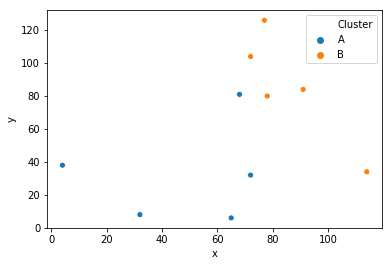

In [134]:
#Dataset 1
n_clusters = 2
datasettestado =  dataset1

top10 = GA()
gera_plot(datasettestado, n_clusters, top10[0])

/home/karine/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/karine/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


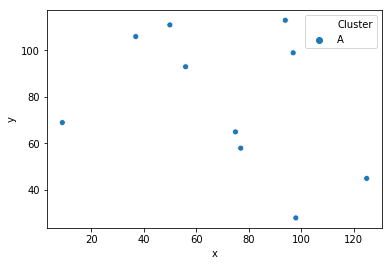

In [75]:
#Dataset 2
n_clusters = 2
datasettestado =  dataset2

top10 = GA()
gera_plot(datasettestado, n_clusters, top10[0])

/home/karine/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/karine/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


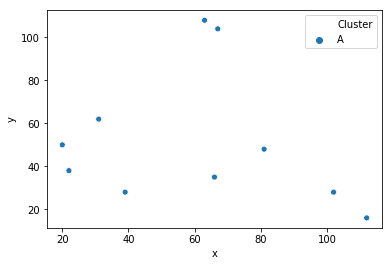

In [76]:
#Dataset 3
n_clusters = 2
datasettestado =  dataset3

top10 = GA()
gera_plot(datasettestado, n_clusters, top10[0])